In [1]:
%pylab inline
from simqso.sqgrids import *
from simqso import sqbase
from simqso.sqmodels import QLF_McGreer_2013

Populating the interactive namespace from numpy and matplotlib


Text(0,0.5,'absolute mag')

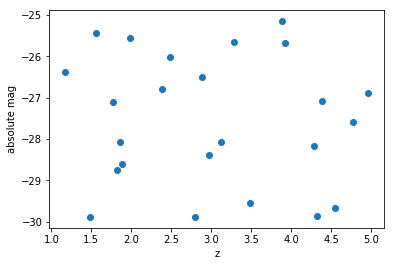

In [2]:
# set up a luminosity-redshift grid
M = AbsMagVar(UniformSampler(-30,-25),restWave=1450)
z = RedshiftVar(UniformSampler(1,5))
MzGrid = QsoSimGrid([M,z],(4,3),2)
scatter(MzGrid.z,MzGrid.absMag,)
xlabel('z')
ylabel('absolute mag')

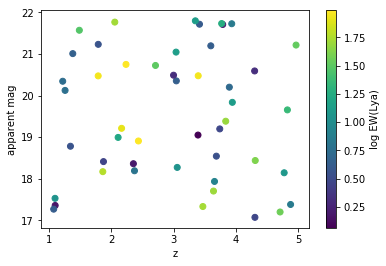

In [3]:
# set up a flux-redshift grid with Lya EW as a third dimension
m = AppMagVar(UniformSampler(17,22),'SDSS-i')
lya = GaussianLineEqWidthVar(UniformSampler(0,2),'LyaEW',1215.67,10.)
mzlyaGrid = QsoSimGrid([m,z,lya],(4,3,2),2)
scatter(mzlyaGrid.z,mzlyaGrid.appMag,c=mzlyaGrid.LyaEW)
cb = colorbar()
xlabel('z')
ylabel('apparent mag')
cb.set_label('log EW(Lya)')

In [4]:
# Generate m,z points by sampling from a model QLF
cosmo = QLF_McGreer_2013.cosmo
kcorr = sqbase.ContinuumKCorr('SDSS-i',1450)
qlfGrid =  generateQlfPoints(QLF_McGreer_2013,
                             (17,22),(4.5,5.3),kcorr,
                             skyArea=100)

integration returned  43  objects


Text(0,0.5,'apparent mag')

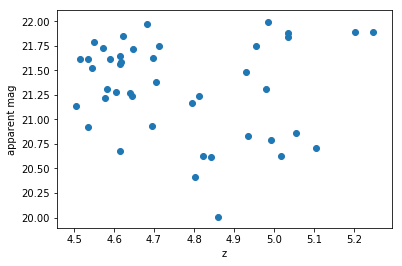

In [5]:
scatter(qlfGrid.z,qlfGrid.appMag)
xlabel('z')
ylabel('apparent mag')

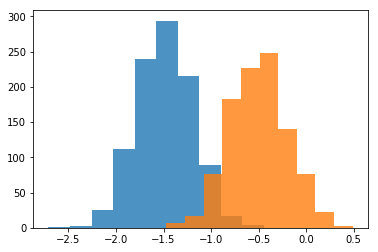

In [6]:
# test the canonical values for power law continuum slopes in FUV/NUV
contVar = BrokenPowerLawContinuumVar([GaussianSampler(-1.5,0.3),GaussianSampler(-0.5,0.3)],[1215.])
contVals = contVar(1000)
_ = hist(contVals[:,0],alpha=0.8)
_ = hist(contVals[:,1],alpha=0.8)

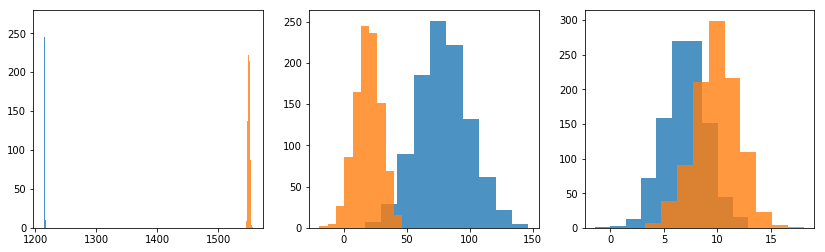

In [7]:
# Add gaussian emission lines
g = GaussianSampler
lya = [g(1215.7,0.5),g(80,20),g(7,2)]
civ = [g(1550.0,1.5),g(20,10),g(10,2)]
emLinesVar = GaussianEmissionLinesTemplateVar([lya,civ])
emLinesVals = emLinesVar(1000)
figure(figsize=(14,4))
for k in range(3):
    subplot(1,3,k+1)
    for j in range(2):
        hist(emLinesVals[:,j,k],alpha=0.8)

In [8]:
# add gaussian lines to the qlf grid
qlfGrid.addVar(emLinesVar)
print(qlfGrid)

 absMag   appMag    z      emLines [2,3]   
-------- ------- ------- ------------------
-25.7022 20.6793 4.61438 1215.39 .. 11.4386
-24.8006 21.5822 4.61733 1216.58 .. 10.0993
-24.6775 21.7192 4.64761 1215.65 .. 10.7054
-26.4813 20.0098 4.85926 1215.99 .. 10.3065
 -24.683 21.7433  4.7127 1216.09 .. 11.8893
-24.5492 21.9963 4.98619 1216.12 .. 9.61178
-24.7329  21.649 4.61517 1214.99 .. 10.4339
-25.1594 21.2359 4.64457  1216.32 .. 8.1718
 -25.238 21.3049 4.98007  1215.51 .. 11.531
-24.5316 21.8533 4.62197 1215.17 .. 11.7897
     ...     ...     ...                ...
-25.1934 21.1366  4.5041 1215.51 .. 9.34076
-24.7977 21.6216 4.69736 1215.97 .. 7.63004
-24.7157  21.619 4.51406 1215.78 .. 11.2653
-24.5587 21.7929  4.5499 1215.83 .. 12.9665
-24.8266 21.5229 4.54543 1215.53 .. 11.8405
-26.0515 20.4149 4.80297 1216.54 .. 11.9984
-25.0982  21.279   4.605 1215.74 .. 13.6779
-25.4834 20.9346 4.69442 1214.94 .. 8.28978
-25.6909 20.8327 4.93463 1215.73 .. 11.2222
-25.9275 20.6317 5.01859 1215.84

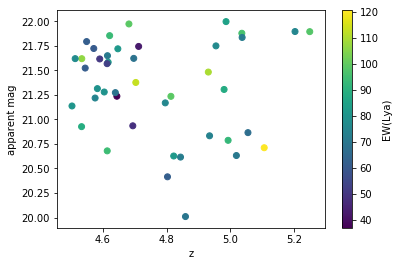

In [9]:
scatter(qlfGrid.z,qlfGrid.appMag,c=qlfGrid.emLines[:,0,1])
cb = colorbar()
xlabel('z')
ylabel('apparent mag')
cb.set_label('EW(Lya)')

In [10]:
# Now use the BOSS DR9 emission line template, including the Baldwin Effect
lineTemplate = generateBEffEmissionLines(qlfGrid.absMag)
lines = lineTemplate()
lines.shape

(43, 62, 3)

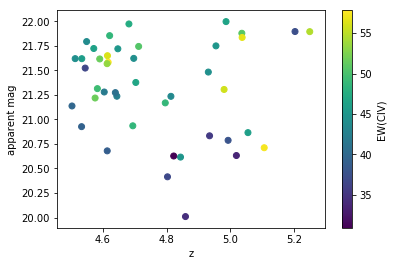

In [11]:
scatter(qlfGrid.z,qlfGrid.appMag,c=lines[:,13,1])
cb = colorbar()
xlabel('z')
ylabel('apparent mag')
cb.set_label('EW(CIV)')

In [12]:
vdblines = generateVdBCompositeEmLines(minEW=0)
vdblines = vdblines(qlfGrid.nObj)

using the following lines from VdB template:  Ly{epsilon},CIII,Ly{beta},ArI,FeIII,CIII*,Ly{alpha},NV,SiII,OI,CII,SiIV,CIV,HeII,OIII],NIV,NIII],FeII,SiII,AlIII,SiIII],CIII],FeIII,FeIII,FeII,FeII,FeII,CII],[NeIV],[OII],FeII,AlII],MgII,FeII,OIII,HeI,FeI,FeII,[NeV],[NeV],FeII,[FeVII],[OII],[FeVII],FeII,FeII,[NeIII],HeI,[NeIII],[FeV],H{delta},FeII,FeII,[FeII],[FeII],H{gamma},[OIII],FeII,FeII,HeII,H{beta},FeII,[OIII],[OIII],[FeVII],[FeVI],[NI],[FeVII],FeII,[FeXIV],[ClIII],[FeVII],HeI,[FeVII],[OI],[OI],[NII],H{alpha},[NII],[SII],[SII],HeI,[ArIII],[OII],[NiIII]


In [13]:
wave = arange(3000,1e4,0.5)
z = 2.0
def quick_spec(emlines):
    lineWave,eqWidth,sigma = emlines.T * (1+z)
    spec = np.zeros_like(wave)
    A = eqWidth/(np.sqrt(2*np.pi)*sigma)
    twosig2 = 2*sigma**2
    nsig = np.sqrt(-2*np.log(1e-3/A))
    nsig = (nsig*np.array([[-1.],[1]])).T
    for i in range(lineWave.shape[0]):
        i1,i2 = np.searchsorted(wave,lineWave[i]+nsig[i]*sigma[i])
        if i2 != i1:
            lineprofile = A[i]*np.exp(-(wave[i1:i2]-lineWave[i])**2
                                       / twosig2[i])
            spec[i1:i2] += lineprofile
    return spec

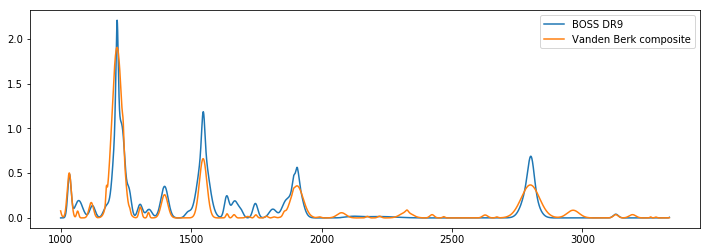

In [14]:
figure(figsize=(12,4))
plot(wave/(1+z),quick_spec(lines[0]),label='BOSS DR9')
plot(wave/(1+z),quick_spec(vdblines[0]),label='Vanden Berk composite')
legend()